<a href="https://colab.research.google.com/github/dsrrenCodes/NTU-datathon-2025-Lifeline/blob/main/NTUdatathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import joblib
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### EDA
- 3 rows with missing values (very small percentage so it is safe to remove)
- Our NSP values are disproportionate, so need to apply SMOTE(Synthetic Minority Over-sampling Technique)
- Although all dtype is numeric, there are some categorical variables (['NSP','CLASS','Tendency','Nzeros','DP','DS'])
- present outliers, need to remove outliers using KNNImputer

In [4]:
#change the file path accordingly
explore=pd.read_excel('/content/CTG.xls',sheet_name=1,header=1)
explore = explore.loc[:, ~explore.columns.str.contains('Unnamed:')]
complete_features=['b','e','LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency','CLASS','NSP']

explore=explore[complete_features]
df=explore.copy()

In [5]:
df.describe()

,b,e,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2127.000000,2127.000000,2128.000000,2128.000000,2128.000000,2127.000000,2127.000000,2127.000000,2127.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,878.439793,1702.877234,133.303857,2.722484,7.503056,3.669017,1.576128,0.003759,0.127820,47.008933,1.335449,9.884814,8.207616,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,894.084748,930.919143,9.840844,3.560850,39.030452,2.877148,2.517794,0.061213,0.471687,17.210648,0.891543,18.476534,5.701926,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,0.000000,287.000000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.000000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,55.000000,1009.000000,126.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,32.000000,0.700000,0.000000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,538.000000,1241.000000,133.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,49.000000,1.200000,0.000000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,1521.000000,2434.750000,140.000000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,61.000000,1.700000,11.000000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,3296.000000,3599.000000,160.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,87.000000,7.000000,91.000000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   LB        2126 non-null   float64
 3   AC        2126 non-null   float64
 4   FM        2127 non-null   float64
 5   UC        2127 non-null   float64
 6   DL        2128 non-null   float64
 7   DS        2128 non-null   float64
 8   DP        2128 non-null   float64
 9   ASTV      2127 non-null   float64
 10  MSTV      2127 non-null   float64
 11  ALTV      2127 non-null   float64
 12  MLTV      2127 non-null   float64
 13  Width     2126 non-null   float64
 14  Min       2126 non-null   float64
 15  Max       2126 non-null   float64
 16  Nmax      2126 non-null   float64
 17  Nzeros    2126 non-null   float64
 18  Mode      2126 non-null   float64
 19  Mean      2126 non-null   float64
 20  Median    2126 non-null   floa

In [7]:
df.head()

,b,e,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,240.0,357.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
1,5.0,632.0,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
2,177.0,779.0,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
3,411.0,1192.0,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
4,533.0,1147.0,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0


In [8]:
df.isna().sum()/len(df) *100

,0
b,0.140911
e,0.140911
LB,0.140911
AC,0.140911
FM,0.093941
UC,0.093941
DL,0.046970
DS,0.046970
DP,0.046970
ASTV,0.093941


<Axes: xlabel='NSP'>

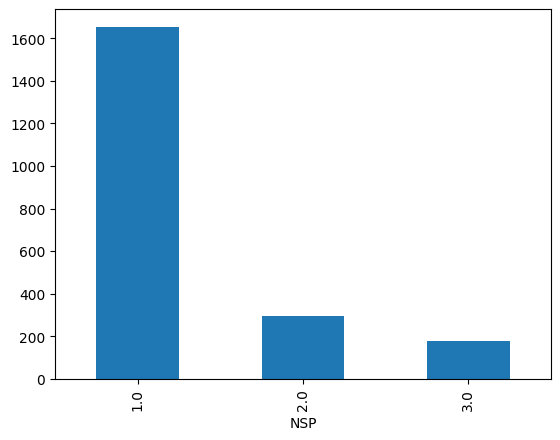

In [9]:
#imbalance data need use smote
df.dropna(subset=['NSP'])['NSP'].value_counts().plot(kind='bar')

In [10]:
df=df.dropna(subset=['NSP'])

In [11]:
#the only nans are only associated with NSP, 3 rows so can just safely remove them
explore[explore['NSP'].isna()]

,b,e,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,NaN,NaN,564.0,23.0,16.0,1.0,4.0,87.0,7.0,91.0,50.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


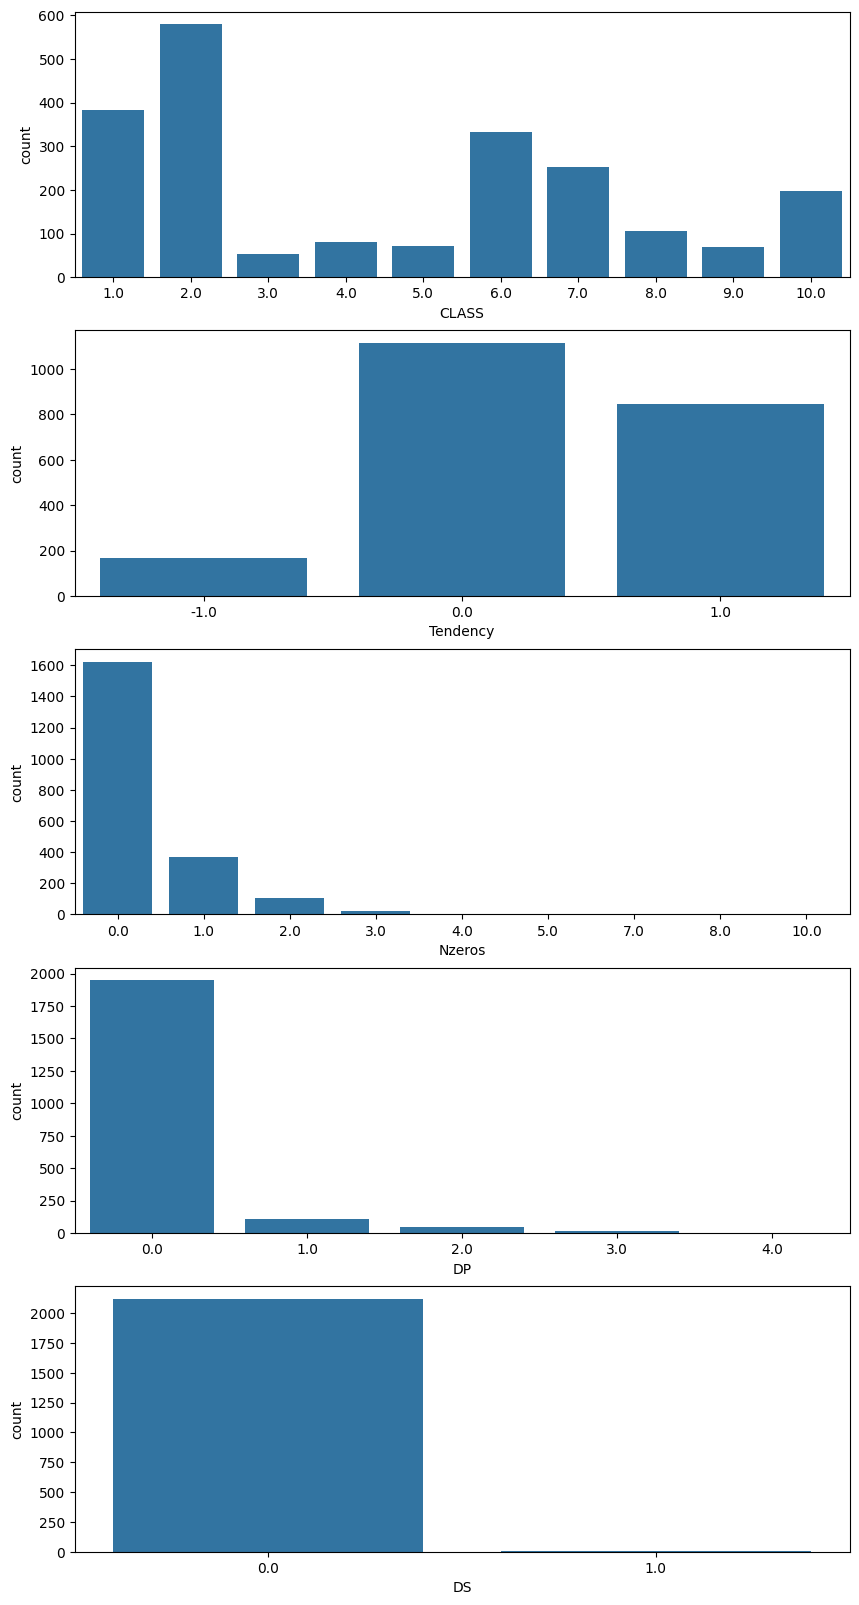

In [12]:
# ['CLASS','Tendency','Nzeros','DP','DS'] clearly categorical
cat_columns=['CLASS','Tendency','Nzeros','DP','DS']
fig,ax = plt.subplots(5,1,figsize=(10,20))
for c in cat_columns:
  sns.countplot(data=explore,x=c,ax=ax[cat_columns.index(c)])

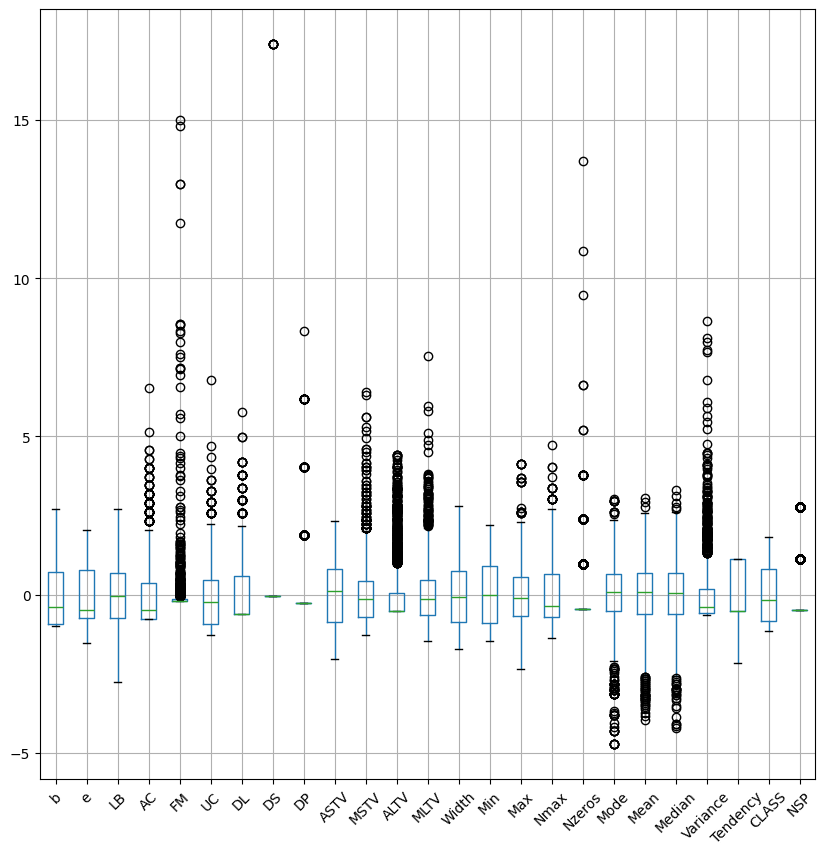

In [13]:
#outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_scale = pd.DataFrame(sklearn.preprocessing.scale(df), columns=df.columns)
df_scale.boxplot(ax=ax, rot=45)
plt.show()

### exploring new features
- created ASTV_MSTV_ratio, ALTV_MLTV_ratio, Heart_Rate_Range, AC_UC_interaction,Variability_Score
- compared their correlation against NSP to checked relevance, discovered(Heart_Rate_Range) not that relevant

In [14]:
print(f"   Created 5 new domain-specific features:")
print(f"   - ASTV_MSTV_ratio: Short-term vs Medium-term variability ratio")
print(f"   - ALTV_MLTV_ratio: Long-term variability ratio")
print(f"   - Heart_Rate_Range: Range of heart rate values")
print(f"   - AC_UC_interaction: Acceleration-Uterine contraction interaction")
print(f"   - Variability_Score: Combined variability measure")



#heart_rate_range
df['heart_rate_range'] = df['Max'] - df['Min']
#ASTV_MSTV_ratio
df['ASTV_MSTV_ratio']= df['ASTV'] / (df['MSTV'] + 1e-8)
#ALTV_MLTV_ratio
df['ALTV_MLTV_ratio']= df['ALTV'] / (df['MLTV'] + 1e-8)
#Variability composite score
df['Variability_Score'] = (df['ASTV'] + df['ALTV']) / 2
#AC_UC_interaction
df['AC_UC_interaction'] = df['AC'] * df['UC']



   Created 5 new domain-specific features:
   - ASTV_MSTV_ratio: Short-term vs Medium-term variability ratio
   - ALTV_MLTV_ratio: Long-term variability ratio
   - Heart_Rate_Range: Range of heart rate values
   - AC_UC_interaction: Acceleration-Uterine contraction interaction
   - Variability_Score: Combined variability measure


heart_rate_range not that correlated to NSP so will exclude heart_rate_range

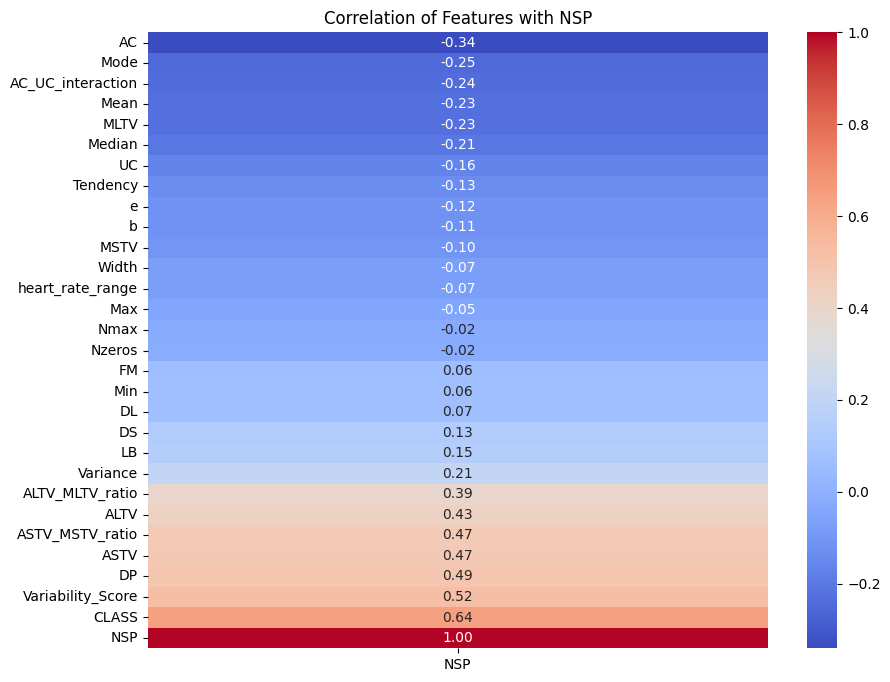

In [15]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df.corr()['NSP'].to_frame().sort_values(by='NSP'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with NSP')
plt.show()

### Numerical analysis

- identifying skewed features
- apply log transformation so that i can apply standardization to them later

In [16]:
cat_var=['NSP','CLASS','Tendency','Nzeros','DP','DS']
num_var=df.columns.difference(cat_var)
#exclude heart_rate_range
num_var=num_var[:-1]

num_var

Index(['AC', 'AC_UC_interaction', 'ALTV', 'ALTV_MLTV_ratio', 'ASTV',
       'ASTV_MSTV_ratio', 'DL', 'FM', 'LB', 'MLTV', 'MSTV', 'Max', 'Mean',
       'Median', 'Min', 'Mode', 'Nmax', 'UC', 'Variability_Score', 'Variance',
       'Width', 'b', 'e'],
      dtype='object')

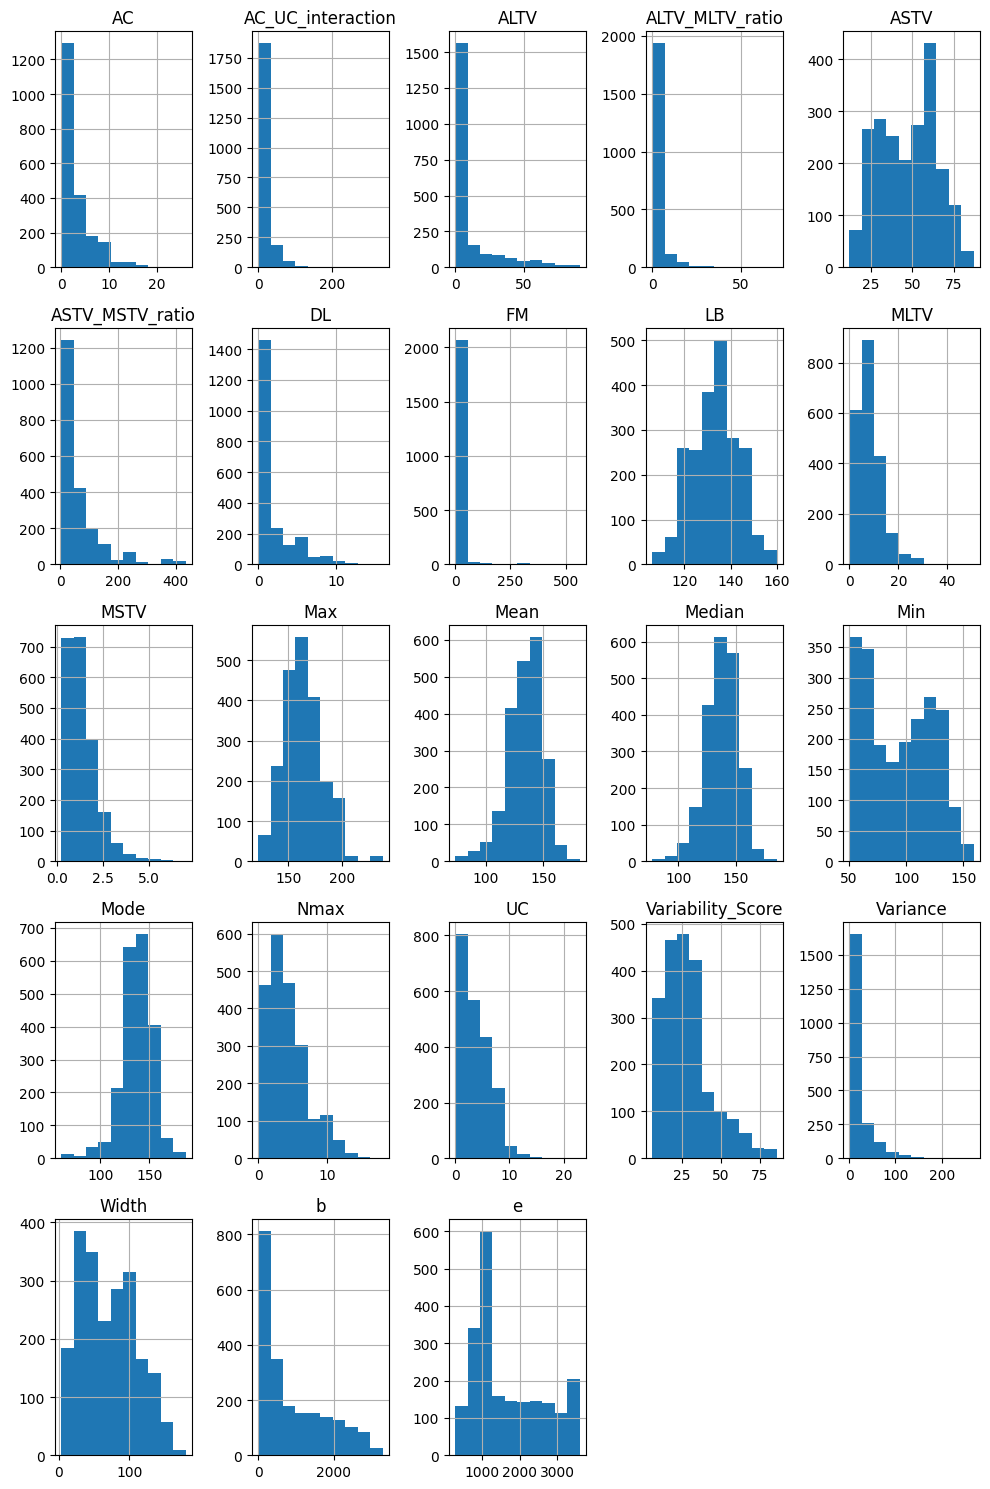

In [17]:
#histogram of all numerical features, so i can see which features are skewed (so we can apply log transformation)
df[num_var].hist(figsize=(10, 15))
plt.tight_layout()
plt.show()

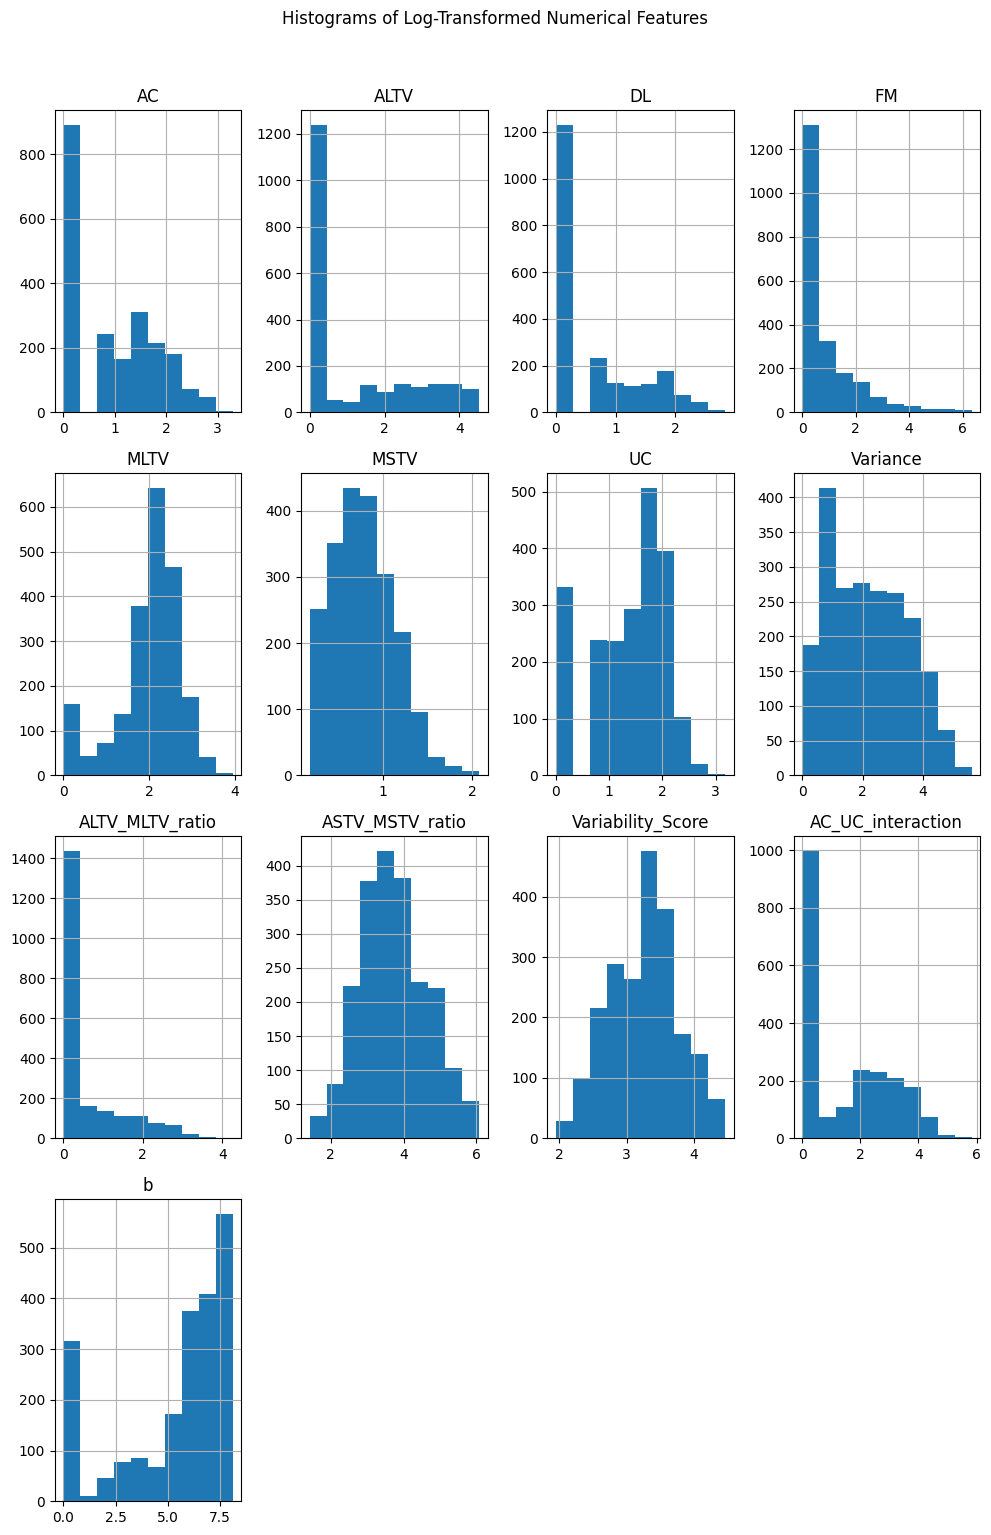

In [18]:
#plot of skewed features after log transformation
features_to_log_transform = [
    "AC",
    "ALTV",
    "DL",
    "FM",
    "MLTV",
    "MSTV",
    "UC",
    "Variance",
    'ALTV_MLTV_ratio',
    'ASTV_MSTV_ratio',
    'Variability_Score',
    'AC_UC_interaction',
    'b']

for feature in features_to_log_transform:
    df[feature] = np.log1p(df[feature])

df[features_to_log_transform].hist(figsize=(10, 15))
plt.suptitle('Histograms of Log-Transformed Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

### Data Preprocessing

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



train test split

In [20]:
#reload data

explore=pd.read_excel('/content/CTG.xls',sheet_name=1,header=1)
explore = explore.loc[:, ~explore.columns.str.contains('Unnamed:')]
complete_features=['b','e','LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency','CLASS','NSP']


explore=explore[complete_features]

df=explore.copy()
df=df.dropna(subset=['NSP'])

#split

y=df['NSP']
X=df.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'len of train data {len(X_train)}')
print(f'len of test data {len(X_test)}')

len of train data 1700
len of test data 426


pipeline for feature engineering/ preprocess data

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
import copy
from sklearn.impute import KNNImputer


num_var=['Max', 'Median', 'Mean', 'ASTV', 'Mode', 'Nmax', 'Min', 'LB', 'Width','e']

features_to_log_transform = [
    "AC",
    "ALTV",
    "DL",
    "FM",
    "MLTV",
    "MSTV",
    "UC",
    "Variance",
    'ALTV_MLTV_ratio',
    'ASTV_MSTV_ratio',
    'Variability_Score',
    'AC_UC_interaction',
    'b']

#adding additional features
def add_features(df):
    df = df.copy()
    df['heart_rate_range'] = df['Max'] - df['Min']
    df['ASTV_MSTV_ratio'] = df['ASTV'] / (df['MSTV'] + 1e-8)
    df['ALTV_MLTV_ratio'] = df['ALTV'] / (df['MLTV'] + 1e-8)
    df['Variability_Score'] = (df['ASTV'] + df['ALTV']) / 2
    df['AC_UC_interaction'] = df['AC'] * df['UC']
    return df

add_features_transformer=FunctionTransformer(add_features)

#log
log_transformer=FunctionTransformer(func=np.log1p,feature_names_out='one-to-one')

#smote for imblanance data
smote=SMOTE(random_state=42)


def outlier_removal(X, threshold=7):
    """ Sets feature values in X that are more than (threshold * feature standard deviation) away from feature mean
    to NaN. Returns X with original length but some column values are NaN. At default value 100, no outlier treatment occurs.
    """
    new_X = copy.deepcopy(X)
    # Use original column names to create a DataFrame from the scaled array
    new_X_scaled = sklearn.preprocessing.scale(X)
    new_X[abs(new_X_scaled) > threshold] = np.nan

    return new_X


zscore_outlier_removal_transformer = sklearn.preprocessing.FunctionTransformer(func=outlier_removal,
    kw_args=dict(threshold=7))



KNN_impute = KNNImputer()

#features_to_log_transform
log_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    zscore_outlier_removal_transformer,
    KNN_impute,
    FunctionTransformer(func=np.log1p,feature_names_out='one-to-one'),
    StandardScaler()
)

#num_var features (no overlap)
default_num_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    zscore_outlier_removal_transformer,
    KNN_impute,
    StandardScaler()
)


preprocessing=ColumnTransformer([
    ('log_pipeline',log_pipeline,features_to_log_transform),
    ('default_num_pipeline',default_num_pipeline,num_var)
])


### Modelling

Main Pipeline example

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score



lr=LogisticRegression()

main_pipeline = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('classifier', lr)
])

main_pipeline

Pipeline(steps=[('add_features',
                 FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('log_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x78da20f89bc0>,
                                                                                       kw_args={'threshold': 7})),
                                                                  ('knn...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x78da20f89bc0>,
                                                                                       kw_args={'threshold': 7})),
                                                                  ('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Max', 'Median', 'Mean',
                                                   'ASTV', 'Mode', 'Nmax',
                                                   'Min', 'LB', 'Width',
                                                   'e'])])),
                ('smote', SMOTE(random_state=42)),
                ('feature_selection', SelectKBest(k=30)),
                ('classifier', LogisticRegression())])

In [23]:
p = df.copy()
p = main_pipeline['add_features'].transform(p)
print(len(p.columns))

30


### Random Forest (with tuning)

In [24]:
from sklearn.ensemble import RandomForestClassifier
tree_numbers = [20, 50, 100, 200,300,400]
tree_depths = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
max_feature_vals = [5, 8, 10, 15,20,25,30]
#k_selection=[20,22,24,25,26,27,28,29,30] not needed for tree models but include this for other models

scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1_macro': 'f1_macro'
}


random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=10, random_state=42, class_weight='balanced')

main_pipeline = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
   # ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('classifier', random_forest)
])

random_forest_grid = {"classifier__n_estimators": tree_numbers,
    "classifier__max_depth": tree_depths,
    "classifier__max_features": max_feature_vals}

random_forest_cv = sklearn.model_selection.RandomizedSearchCV(main_pipeline, random_forest_grid,
    scoring=scoring, n_jobs=-1, refit='f1_macro', verbose=True, return_train_score=True, cv=10)
random_forest_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('add_features',
                                              FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                                             ('preprocess',
                                              ColumnTransformer(transformers=[('log_pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer-1',
                                                                                                FunctionTransformer(func=<function outlier_removal at 0x78da20f89b...
                                                                     max_depth=2,
                                                                     max_features=10,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10],
                                        'classifier__max_features': [5, 8, 10,
                                                                     15, 20, 25,
                                                                     30],
                                        'classifier__n_estimators': [20, 50,
                                                                     100, 200,
                                                                     300,
                                                                     400]},
                   refit='f1_macro', return_train_score=True,
                   scoring={'balanced_accuracy': 'balanced_accuracy',
                            'f1_macro': 'f1_macro'},
                   verbose=True)

In [25]:
from sklearn.metrics import f1_score, balanced_accuracy_score
pred=random_forest_cv.best_estimator_.predict(X_test)
print(f'RANDOM FOREST CLASSIFIER: \n')
print(f'test balance accuracy score: {balanced_accuracy_score(y_test,pred)}')
print(f'test f1 score: {f1_score(y_test,pred,average='macro')}')
print("\nClassification Report:\n", classification_report(y_test, pred))

RANDOM FOREST CLASSIFIER: 

test balance accuracy score: 0.9216107271064168
test f1 score: 0.8973260774007418

Classification Report:
               precision    recall  f1-score   support

         1.0       0.97      0.94      0.96       333
         2.0       0.75      0.86      0.80        64
         3.0       0.90      0.97      0.93        29

    accuracy                           0.93       426
   macro avg       0.88      0.92      0.90       426
weighted avg       0.93      0.93      0.93       426



In [26]:
#store pipeline and model

random_forest_main_pipeline=random_forest_cv.best_estimator_
best_random_forest_model_pipeline=random_forest_cv.best_estimator_
joblib.dump(random_forest_main_pipeline, 'random_forest_model_pipeline')

joblib.dump(random_forest_main_pipeline['classifier'],'random_forest_model')

['random_forest_model']

### gradient boosting classifier (with tuning)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.model_selection

scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1_macro': 'f1_macro'
}

tree_numbers = [20, 50, 100, 200, 300, 400]
tree_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_feature_vals = [5, 8, 10, 15, 20, 25, 30]


gradient_boosting = GradientBoostingClassifier(random_state=42)


main_pipeline_gb = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', gradient_boosting)
])

# Hyperparameter search grid
gradient_boosting_grid = {
    "classifier__n_estimators": tree_numbers,
    "classifier__max_depth": tree_depths,
    "classifier__max_features": max_feature_vals
}

gradient_boosting_cv = sklearn.model_selection.RandomizedSearchCV(
    main_pipeline_gb,
    gradient_boosting_grid,
    scoring=scoring,
    n_jobs=-1,
    refit='f1_macro',
    verbose=True,
    return_train_score=True,
    cv=10
)


gradient_boosting_cv.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('add_features',
                                              FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                                             ('preprocess',
                                              ColumnTransformer(transformers=[('log_pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer-1',
                                                                                                FunctionTransformer(func=<function outlier_removal at 0x78da20f89b...
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': [1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10],
                                        'classifier__max_features': [5, 8, 10,
                                                                     15, 20, 25,
                                                                     30],
                                        'classifier__n_estimators': [20, 50,
                                                                     100, 200,
                                                                     300,
                                                                     400]},
                   refit='f1_macro', return_train_score=True,
                   scoring={'balanced_accuracy': 'balanced_accuracy',
                            'f1_macro': 'f1_macro'},
                   verbose=True)

In [28]:
pred=gradient_boosting_cv.best_estimator_.predict(X_test)
print(f'GRADIENT BOOSTING CLASSIFIER: \n')
print(f'test balance accuracy score: {balanced_accuracy_score(y_test,pred)}')
print(f'test f1 score: {f1_score(y_test,pred,average='macro')}')
print(classification_report(y_test,pred))

GRADIENT BOOSTING CLASSIFIER: 

test balance accuracy score: 0.9430384047840944
test f1 score: 0.9446051024998393
              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97       333
         2.0       0.86      0.89      0.88        64
         3.0       1.00      0.97      0.98        29

    accuracy                           0.96       426
   macro avg       0.95      0.94      0.94       426
weighted avg       0.96      0.96      0.96       426



In [29]:
gradient_boosting_main_pipeline=gradient_boosting_cv.best_estimator_

In [30]:
#saving model and pipeline
best_gbm_model_pipeline=gradient_boosting_cv.best_estimator_

joblib.dump(gradient_boosting_main_pipeline, 'gradient_boosting_model_pipeline')

joblib.dump(gradient_boosting_main_pipeline['classifier'],'gradient_boosting_model')

['gradient_boosting_model']

### XGB Classifier (with tuning)

In [31]:
import xgboost
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train)


param_dist = {
    'classifier__max_depth': randint(3, 12),          # Depth range for each tree
    'classifier__learning_rate': uniform(0.01, 0.3),  # Step size shrinkage, commonly in [0.01, 0.3]
    'classifier__n_estimators': randint(100, 1000),   # Number of boosting rounds
    'classifier__subsample': uniform(0.6, 0.4),       # Fraction of samples used per tree (0.6 to 1.0)
    'classifier__colsample_bytree': uniform(0.5, 0.5),# Fraction of features used per tree (0.5 to 1.0)
    'classifier__min_child_weight': randint(1, 10),   # Minimum sum of instance weight (hessian) in a child
    'classifier__gamma': uniform(0, 5),               # Minimum loss reduction for further split
    'classifier__reg_alpha': uniform(0, 1),           # L1 regularization on weights
    'classifier__reg_lambda': uniform(1, 2)           # L2 regularization on weights
}


xgb_clf = xgboost.XGBClassifier(random_state=42)


main_pipeline_xgb = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', xgb_clf)
])


xgb_cv=sklearn.model_selection.RandomizedSearchCV(
    main_pipeline_xgb,
    param_dist,
    scoring=scoring,
    n_jobs=-1,
    refit='f1_macro',
    verbose=True,
    return_train_score=True,
    cv=10
)

xgb_cv.fit(X_train, y_train_xgb)

pred = le.inverse_transform(xgb_cv.best_estimator_.predict(X_test))

print(print(f'XGB CLASSIFIER: \n'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, pred))
print("F1 Score (macro):", f1_score(y_test, pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
XGB CLASSIFIER: 

None
Balanced Accuracy: 0.9256147311104207
F1 Score (macro): 0.9000283252170692

Classification Report:
               precision    recall  f1-score   support

         1.0       0.98      0.95      0.96       333
         2.0       0.81      0.86      0.83        64
         3.0       0.85      0.97      0.90        29

    accuracy                           0.94       426
   macro avg       0.88      0.93      0.90       426
weighted avg       0.94      0.94      0.94       426



In [32]:
best_xgb_model_pipeline=xgb_cv.best_estimator_

joblib.dump(xgb_cv.best_estimator_, 'XGB_model_pipeline')

joblib.dump(xgb_cv.best_estimator_['classifier'],'XGB_model')



['XGB_model']

### logistic regression (with tuning)

In [33]:
from sklearn.linear_model import LogisticRegression


lr=LogisticRegression()

scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1_macro': 'f1_macro'
}


logistic_regression_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'classifier__C': np.logspace(-4, 4, 10),
        'feature_selection__k': [20, 22, 24, 26, 28, 30],
        'classifier__max_iter': [1000, 2000]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['saga'],
        'classifier__C': np.logspace(-4, 4, 10),
        'feature_selection__k': [20, 22, 24, 26, 28, 30],
        'classifier__max_iter': [1000, 2000]
    },
    {
        'classifier__penalty': ['none'],
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'classifier__C': np.logspace(-4, 4, 10),
        'feature_selection__k': [20, 22, 24, 26, 28, 30],
        'classifier__max_iter': [1000, 2000]
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__C': np.logspace(-4, 4, 10),
        'feature_selection__k': [20, 22, 24, 26, 28, 30],
        'classifier__max_iter': [1000, 2000],
        'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
    }
]

main_pipeline_logistic_regression = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
   ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', lr)
])


logistic_regression_cv = sklearn.model_selection.RandomizedSearchCV(
    main_pipeline_logistic_regression,
    logistic_regression_grid,
    scoring=scoring,
    n_jobs=-1,
    refit='f1_macro',
    verbose=True,
    return_train_score=True,
    cv=10
)
logistic_regression_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('add_features',
                                              FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                                             ('preprocess',
                                              ColumnTransformer(transformers=[('log_pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer-1',
                                                                                                FunctionTransformer(func=<function outlier_removal at 0x78da20f89b...
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                                         'classifier__l1_ratio': [0, 0.25, 0.5,
                                                                  0.75, 1],
                                         'classifier__max_iter': [1000, 2000],
                                         'classifier__penalty': ['elasticnet'],
                                         'classifier__solver': ['saga'],
                                         'feature_selection__k': [20, 22, 24,
                                                                  26, 28,
                                                                  30]}],
                   refit='f1_macro', return_train_score=True,
                   scoring={'balanced_accuracy': 'balanced_accuracy',
                            'f1_macro': 'f1_macro'},
                   verbose=True)

In [34]:
logistic_regression_cv.best_score_

np.float64(0.8025855511765505)

In [35]:
pred=logistic_regression_cv.best_estimator_.predict(X_test)
print(f'LOGISTIC REGRESSION: \n')
print(f'test balance accuracy score: {balanced_accuracy_score(y_test,pred)}')
print(f'test f1 score: {f1_score(y_test,pred,average='macro')}')
print("\nClassification Report:\n", classification_report(y_test, pred))

LOGISTIC REGRESSION: 

test balance accuracy score: 0.8434749404576992
test f1 score: 0.7581908831908831

Classification Report:
               precision    recall  f1-score   support

         1.0       0.98      0.86      0.91       333
         2.0       0.57      0.81      0.67        64
         3.0       0.58      0.86      0.69        29

    accuracy                           0.85       426
   macro avg       0.71      0.84      0.76       426
weighted avg       0.89      0.85      0.86       426



In [36]:
best_logistic_model=logistic_regression_cv.best_estimator_['classifier']

joblib.dump(logistic_regression_cv.best_estimator_, 'lr_pipeline')

joblib.dump(logistic_regression_cv.best_estimator_['classifier'],'lr_model')

['lr_model']

### stack classifier

In [38]:
rf=joblib.load('/content/random_forest_model_pipeline')
gbm=joblib.load('/content/gradient_boosting_model_pipeline')
xgb=joblib.load('/content/XGB_model_pipeline')
lg=joblib.load('/content/lr_pipeline')

In [39]:
rf_best_params=rf['classifier'].get_params()
gbm_best_params=gbm['classifier'].get_params()
xgb_best_params=xgb['classifier'].get_params()
lg_best_params=lg['classifier'].get_params()

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

models = [('rf', RandomForestClassifier(**rf_best_params)), ('gbn',GradientBoostingClassifier(**gbm_best_params)),
    ('xgb', xgboost.XGBClassifier(**xgb_best_params)),('logistic',LogisticRegression(**lg_best_params))]

stack = StackingClassifier(models, cv=5, stack_method='auto')

stack_pipeline = ImbPipeline([
    ('add_features', add_features_transformer),
    ('preprocess', preprocessing),
    ('smote', smote),
    ('classifier', stack)
])

stack_pipeline.fit(X_train,y_train)

Pipeline(steps=[('add_features',
                 FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('log_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x78da20f89bc0>,
                                                                                       kw_args={'threshold': 7})),
                                                                  ('knn...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=6,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=963,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('logistic',
                                                 LogisticRegression(C=np.float64(21.54434690031882),
                                                                    l1_ratio=0.25,
                                                                    max_iter=2000,
                                                                    penalty='elasticnet',
                                                                    solver='saga'))]))])

In [41]:
pred=stack_pipeline.predict(X_test)
print(f'STACKED CLASSIFIER: \n')
print(f'test balance accuracy score: {balanced_accuracy_score(y_test,pred)}')
print(f'test f1 score: {f1_score(y_test,pred,average='macro')}')
print("\nClassification Report:\n", classification_report(y_test, pred))

STACKED CLASSIFIER: 

test balance accuracy score: 0.9358280694487591
test f1 score: 0.9273444623394774

Classification Report:
               precision    recall  f1-score   support

         1.0       0.98      0.97      0.97       333
         2.0       0.85      0.88      0.86        64
         3.0       0.93      0.97      0.95        29

    accuracy                           0.95       426
   macro avg       0.92      0.94      0.93       426
weighted avg       0.95      0.95      0.95       426



In [42]:
#dumping stacking classifier pipeline and model
joblib.dump(stack_pipeline, 'stack_pipeline')

joblib.dump(stack_pipeline['classifier'],'stack_pipeline_model')

['stack_pipeline_model']

### BEST MODEL : Gradient boosting classifier. Example use case

In [48]:
#reload the data:
explore=pd.read_excel('/content/CTG.xls',sheet_name=1,header=1)
explore = explore.loc[:, ~explore.columns.str.contains('Unnamed:')]
complete_features=['b','e','LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency','CLASS','NSP']

explore=explore[complete_features]
df=explore.copy()

#remove Y variables to stimulate test data
df=df.drop(columns=['NSP'])

def labels_to_results(df, label_col='predicted_label'):
    label_map = {1: 'Normal', 2: 'Suspect', 3: 'Pathologic'}
    df['results'] = df[label_col].map(label_map)
    return df



#load the model pipeline from the joblib (gradient boosting classifer model pipeline)
final_model_pipeline = joblib.load('/content/gradient_boosting_model_pipeline')

df['pred']=final_model_pipeline.predict(df)
df=labels_to_results(df,label_col='pred')

#dump best model
joblib.dump(final_model_pipeline, 'best_model_pipeline')



['best_model_pipeline']

In [52]:
final_model_pipeline

Pipeline(steps=[('add_features',
                 FunctionTransformer(func=<function add_features at 0x78da20f89c60>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('log_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer-1',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x78da20f89bc0>,
                                                                                       kw_args={'threshold': 7})),
                                                                  ('knn...
                                                                   FunctionTransformer(func=<function outlier_removal at 0x78da20f89bc0>,
                                                                                       kw_args={'threshold': 7})),
                                                                  ('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Max', 'Median', 'Mean',
                                                   'ASTV', 'Mode', 'Nmax',
                                                   'Min', 'LB', 'Width',
                                                   'e'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=8, max_features=15,
                                            n_estimators=400,
                                            random_state=42))])